In [4]:
# make the code as Python 3 compatible as possible                                                                            
from __future__ import print_function, division, absolute_import

from collections import OrderedDict
import pypsa

import pandas as pd

import matplotlib.pyplot as plt

from math import radians, cos, sin, asin, sqrt

#import regions

#from mpl_toolkits.basemap import Basemap

from matplotlib.patches import Wedge, Rectangle, Circle

from matplotlib.legend_handler import HandlerPatch

from matplotlib.pyplot import Line2D

import numpy as np

%matplotlib inline

In [2]:

def annuity(n,r):
    """Calculate the annuity factor for an asset with lifetime n years and
    discount rate of r, e.g. annuity(20,0.05)*20 = 1.6"""

    n = float(n)
    r = float(r)

    if r == 0:
        return 1/n
    else:
        return r/(1. -1./(1.+r)**n)

def haversine(p1,p2):
    """Calculate the great circle distance in km between two points on 
    the earth (specified in decimal degrees)
    """

    # convert decimal degrees to radians         
    lon1, lat1, lon2, lat2 = map(radians, [p1[0], p1[1], p2[0], p2[1]])

    # haversine formula                                     
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles 
    return c * r


In [3]:


vre_techs = ["offwind","onwind","solar","ror"]
conv_techs = ["OCGT"]
storage_techs = [u'PHS', u'hydro', u'H2', u'battery']

tech_colors = {"onwind" : "b",
               'offwind' : "c",
               "hydro" : "g",
               "ror" : "turquoise",
               'solar' : "y",
               "OCGT" : "brown",
               "OCGT marginal" : "sandybrown",
               "gas" : "brown",
               "lines" : "k",
               "H2" : "m",
               "battery" : "slategray",
               "Nuclear" : "r",
               "Nuclear marginal" : "r",
               "Coal" : "k",
               "Coal marginal" : "k",
               "Lignite" : "grey",
               "Lignite marginal" : "grey",
               "CCGT" : "orange",
               "CCGT marginal" : "orange"}
nice_names = {"offwind":"offshore wind","onwind" : "onshore wind", "OCGT" : "gas", "H2":"hydrogen storage","battery" : "battery storage","OCGT marginal" : "gas (marginal)","lines" : "transmission lines", "ror" : "run of river"}
nice_names_n = {"offwind":"offshore\nwind","onwind" : "onshore\nwind", "OCGT" : "gas", "H2":"Hydrogen\nstorage","OCGT marginal" : "gas (marginal)", "lines" : "transmission\nlines", "ror" : "run of river"}

In [4]:
csv_folder_name = "/home/tom/results/opteu_paper6-v2g/diw2030-CO0.0-T0_8760-wWsgrpHb-LV0.0_c0_opteu_paper6-v2g-2017-02-17-14-25-36/"
network = pypsa.Network(csv_folder_name=csv_folder_name)

INFO:pypsa.io:buses.csv found.
INFO:pypsa.io:carriers.csv found.
INFO:pypsa.io:generators.csv found.
INFO:pypsa.io:No lines.csv found.
INFO:pypsa.io:No line_types.csv found.
INFO:pypsa.io:links.csv found.
INFO:pypsa.io:loads.csv found.
INFO:pypsa.io:No shunt_impedances.csv found.
INFO:pypsa.io:storage_units.csv found.
INFO:pypsa.io:stores.csv found.
INFO:pypsa.io:No transformers.csv found.
INFO:pypsa.io:No transformer_types.csv found.


In [5]:
path="/home/tom/fias/lib/data/de_model/scigrid-with-load-gen-trafos/generators-p_max_pu.csv"
scigrid=pd.read_csv(path,index_col=0)


#348 is Berlin/Mitte
berlin = scigrid["348 Wind Onshore"]

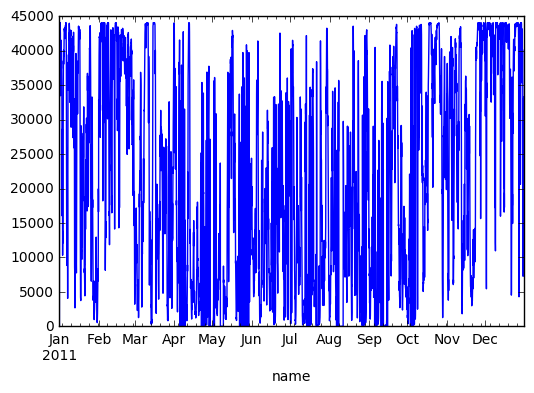

In [6]:
network.generators_t.p["DE offwind"].plot()

In [7]:
p_series = pd.concat((network.generators_t.p.groupby(network.generators.carrier,axis=1).sum(),
                      network.storage_units_t.p.groupby(network.storage_units.carrier,axis=1).sum(),
                      ),
                     axis=1)

In [8]:
p_series_avail = network.generators_t.p_max_pu.multiply(network.generators.p_nom_opt).groupby(network.generators.carrier,axis=1).sum()

p_series_avail.rename(columns={col: col+" available" for col in p_series_avail.columns},inplace=True)


In [9]:
load = p_series.sum(axis=1)

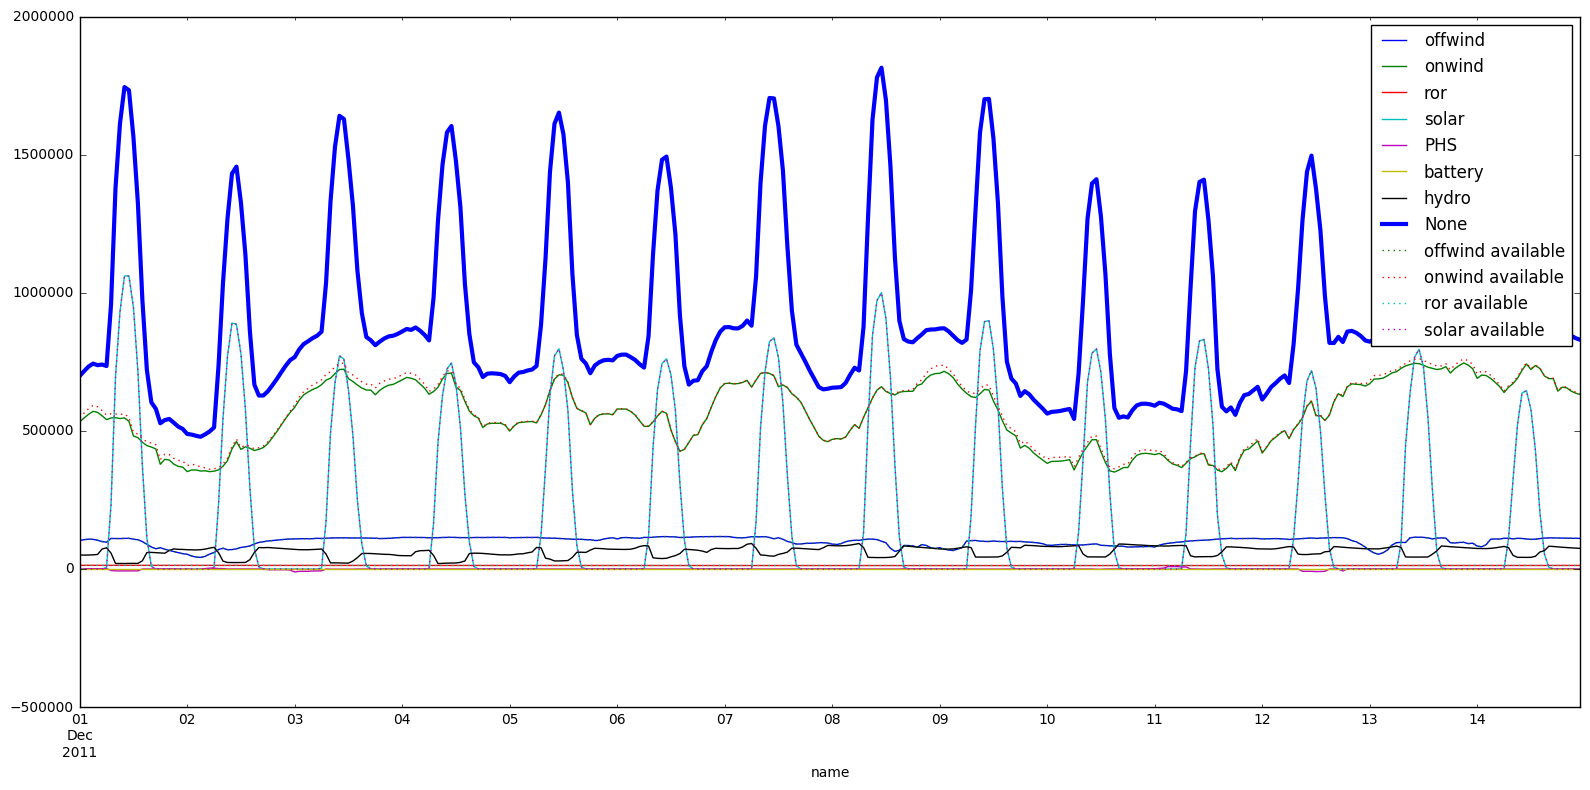

In [10]:
fig,ax = plt.subplots(1,1)

fig.set_size_inches(16,8)


start = "2011-12-01"
end = "2011-12-14"
p_series.loc[start:end].plot(ax=ax)

load[start:end].plot(linewidth=3,ax=ax)

p_series_avail.loc[start:end].plot(ax=ax,linestyle=":")

ax.legend(loc="upper right")

fig.tight_layout()

#fig.savefig("/home/tom/Downloads/"+country+".pdf")


In [11]:
#check power balances in every hour
(abs(p_series.sum(axis=1) - network.loads_t.p_set.sum(axis=1)) > 1).any()

True

In [12]:
country = "IT"

p_series_ct = pd.concat((network.generators_t.p[network.generators[network.generators.bus==country].index],
                      network.storage_units_t.p[network.storage_units[network.storage_units.bus==country].index]),axis=1)

In [13]:
p_series_avail_ct = network.generators_t.p_max_pu[network.generators[network.generators.bus==country].index].multiply(network.generators.p_nom_opt[network.generators.bus==country])

p_series_avail_ct.drop(country+" OCGT",axis=1,inplace=True)
p_series_avail_ct.rename(columns={col: col+" available" for col in p_series_avail_ct.columns},inplace=True)


ValueError: labels ['IT OCGT'] not contained in axis

In [ ]:

fig,ax = plt.subplots(1,1)

fig.set_size_inches(16,8)



start = "2011-06-01"
end = "2011-06-28"
p_series_ct.loc[start:end].plot(ax=ax)

p_series_ct.sum(axis=1)[start:end].plot(linewidth=3,color="brown",label="demand",ax=ax)

p_series_avail_ct.loc[start:end].plot(ax=ax)


fig.tight_layout()

#fig.savefig("/home/tom/Downloads/"+country+".pdf")

In [14]:
network.storage_units_t.inflow["NO hydro"].sum(),network.loads_t.p_set["NO"].sum()

(132230222.77540889, 123150935.0)

In [15]:
network.generators_t.p["NO OCGT"].plot()

KeyError: 'NO OCGT'

# Compare site/country/Europe

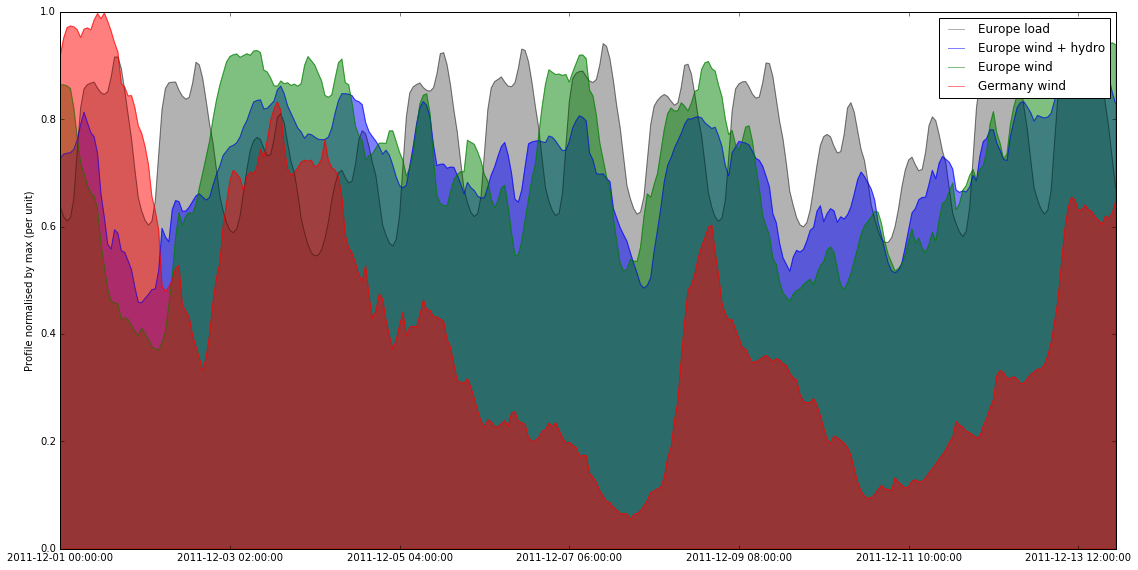

In [19]:

tech = "onwind"

norm = "max"

start = "2011-12-01"
end = "2011-12-14"


fig,ax = plt.subplots(1,1)

fig.set_size_inches(16,8)


(load/getattr(load,norm)()).loc[start:end].plot(kind="area",alpha=0.3,color="k",ax=ax,label="Europe load")

(p_series[[tech,"hydro"]].sum(axis=1)/getattr(p_series[[tech,"hydro"]].sum(axis=1),norm)()).loc[start:end].plot(kind="area",alpha=0.5,ax=ax,label="Europe wind + hydro")

(p_series_avail/getattr(p_series_avail,norm)()).loc[start:end,tech + " available"].plot(kind="area",alpha=0.5,ax=ax,label="Europe wind")

(p_series_avail_ct/getattr(p_series_avail_ct,norm)()).loc[start:end,country+ " " + tech + " available"].plot(kind="area",alpha=0.5,ax=ax,label="Germany wind")

ax.legend()

ax.set_ylabel("Profile normalised by "+norm+" (per unit)")

ax.set_xlabel("")

fig.tight_layout()

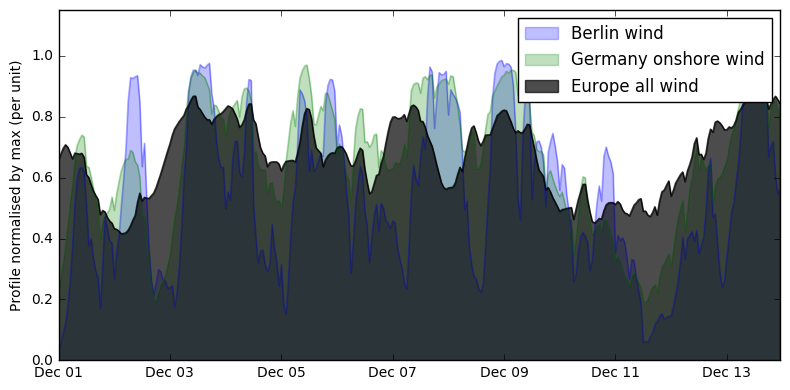

In [61]:

tech = "onwind"

norm = "max"

start = "2011-12-01"
end = "2011-12-14"

fig,ax = plt.subplots(1,1)

fig.set_size_inches(8,4)


version = "eu"  # must be berlin, de or eu

handles = []
labels = []

ct = "DE"

de = network.generators_t.p_max_pu.loc[:,(network.generators.bus == ct) & (network.generators.carrier == tech)].mean(axis=1)

p_series_avail = network.generators_t.p_max_pu.multiply(network.generators.p_nom_opt).groupby(network.generators.carrier,axis=1).sum()



selection = ["onwind","offwind"]

#selection = ["onwind"]

totalcap = network.generators.groupby(network.generators.carrier).sum().p_nom_opt[selection].sum()


eu = (p_series_avail[selection].sum(axis=1)/totalcap)


if version == "berlin":
    alpha = 0.8
else:
    alpha = 0.25
color = "b"
berlin.loc[start:end].plot(kind="area",ax=ax,color=color,alpha=alpha,linewidth=1)

#ax(1,"../wsopt_C05_wWsgrpHb_LV_crossover/Hir-CO10-T0_8760-wWsgrpHb-LV1.0_c0-2016-05-18-14-33-11"),
handles.append(Rectangle((0, 0), 1, 1, fc=color, color=color,alpha = alpha))
labels.append("Berlin wind")

#(p_series[[tech,"hydro"]].sum(axis=1)/getattr(p_series[[tech,"hydro"]].sum(axis=1),norm)()).loc[start:end].plot(kind="area",alpha=0.5,ax=ax,label="Europe wind + hydro")



if version == "de":
    alpha = 0.8
else:
    alpha = 0.25

if version in ["de","eu"]:
    color="g"
    de.loc[start:end].plot(kind="area",ax=ax,color=color,alpha=alpha,linewidth=1)
    handles.append(Rectangle((0, 0), 1, 1, fc=color, color=color,alpha = alpha))
    labels.append("Germany onshore wind")


if version == "eu":
    color="k"
    alpha=0.7
    eu.loc[start:end].plot(kind="area",alpha=alpha,ax=ax,color=color,linewidth=1)
    handles.append(Rectangle((0, 0), 1, 1, fc=color,color=color,alpha=alpha))
    labels.append("Europe all wind")

    
#s = p_series[selection].sum(axis=1)+network.storage_units_t.p.sum(axis=1)
#(s/s.max()).loc[start:end].plot(ax=ax,linewidth=5,color="r")

#(load/load.max()).loc[start:end].plot(ax=ax,linewidth=5,color="r")
#((p_series_avail[selection].sum(axis=1)+network.storage_units_t.p.groupby(network.storage_units.source,axis=1).sum()["hydro"])/totalcap).loc[start:end].plot(kind="area",alpha=0.7,ax=ax,label="Europe all wind + hdyro",color="r")

                
                

#(p_series_avail_ct/getattr(p_series_avail_ct,norm)()).loc[start:end,country+ " " + tech + " available"].plot(kind="area",alpha=0.5,ax=ax,label="Germany wind")

ax.legend(handles,labels)

ax.set_ylabel("Profile normalised by "+norm+" (per unit)")

ax.set_xlabel("")

ax.set_ylim([0,1.15])

ticks = range(0,24*14,48)

ax.set_xticks(ticks)

ax.set_xticklabels(["Dec " + berlin.loc[start:end].index[i][8:10]  for i in ticks])

fig.tight_layout()

if False:
    fig.savefig("variability-{}.pdf".format(version),transparent=True)

In [15]:
eu.describe()

count    8759.000000
mean        0.362297
std         0.191915
min         0.033933
25%         0.208092
50%         0.331001
75%         0.490835
max         0.914824
dtype: float64

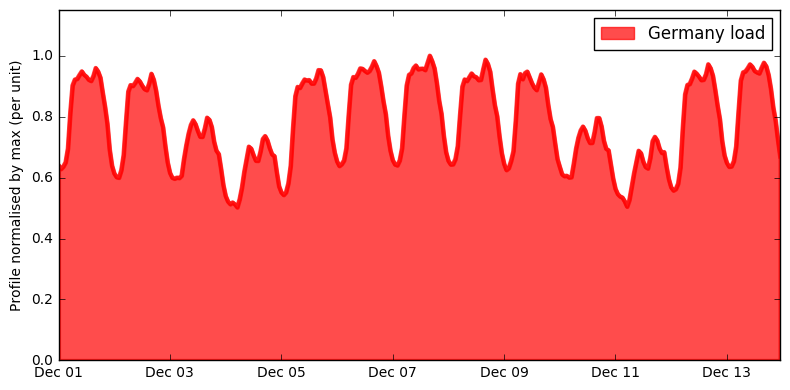

In [35]:

ct = "DE"
start = "2011-12-01"
end = "2011-12-14"

fig,ax = plt.subplots(1,1)

fig.set_size_inches(8,4)


version = "eu"  # must be berlin, de or eu

handles = []
labels = []


color = "r"

alpha =0.7

ct_l = network.loads_t.p_set["DE"]

(ct_l/ct_l.max()).loc[start:end].plot(kind="area",ax=ax,color=color,alpha=alpha,linewidth=3)


handles.append(Rectangle((0, 0), 1, 1, fc=color, color=color,alpha = alpha))
labels.append("Germany load")

ax.legend(handles,labels)

ax.set_ylabel("Profile normalised by "+norm+" (per unit)")

ax.set_xlabel("")

ax.set_ylim([0,1.15])

ticks = range(0,24*14,48)

ax.set_xticks(ticks)

ax.set_xticklabels(["Dec " + berlin.loc[start:end].index[i][8:10]  for i in ticks])

fig.tight_layout()

if False:
    fig.savefig("DE-load.pdf".format(version),transparent=True)

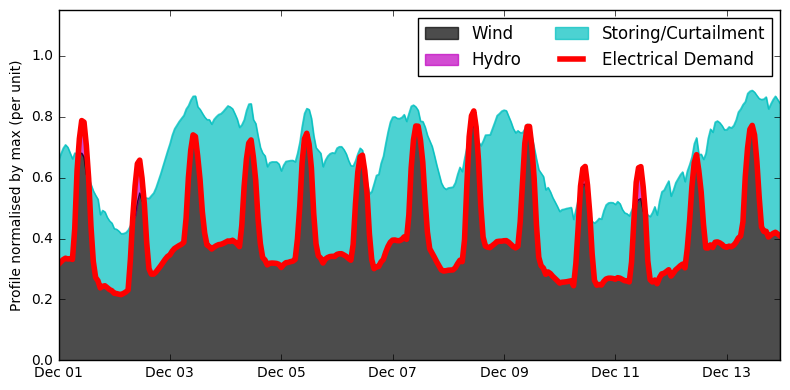

In [28]:

tech = "onwind"

norm = "max"

start = "2011-12-01"
end = "2011-12-14"

fig,ax = plt.subplots(1,1)

fig.set_size_inches(8,4)

handles = []
labels = []
 
#s = p_series[selection].sum(axis=1)+network.storage_units_t.p.sum(axis=1)
#(s/s.max()).loc[start:end].plot(ax=ax,linewidth=5,color="r")

#(load/load.max()).loc[start:end].plot(ax=ax,linewidth=5,color="r",label="load")
#((p_series_avail[selection].sum(axis=1)+network.storage_units_t.p.groupby(network.storage_units.source,axis=1).sum()["hydro"])/totalcap).loc[start:end].plot(kind="area",alpha=0.7,ax=ax,label="Europe all wind + hdyro",color="r")

diff = (load/load.max()-eu).loc[start:end]

diffp = diff.copy()

diffp[diff<0] = 0.

diffn = diff.copy()

diffn[diffn>0] = 0.

#diffp.loc[start:end].plot()

#diffn.loc[start:end].plot()


eus = pd.DataFrame()

eus["Wind"] = eu.loc[start:end]+diffn

eus["Hydro"] = diffp

eus["Storing/Curtailment"] = -diffn

color = ["k","m","c"]
alpha = 0.7

eus.loc[start:end].plot(kind="area",alpha=alpha,ax=ax,color=color,linewidth=1)

handles.extend([Rectangle((0, 0), 1, 1, color=color, fc=color, alpha=alpha) for color in color])
labels.extend(["Wind","Hydro","Storing/Curtailment"])




#(p_series_avail_ct/getattr(p_series_avail_ct,norm)()).loc[start:end,country+ " " + tech + " available"].plot(kind="area",alpha=0.5,ax=ax,label="Germany wind")

#ax.fill_between(diff.index,eu,eu+diffp,color="m",alpha=0.7,label="hydro")

color="r"
linewidth=4
(load/load.max()).loc[start:end].plot(ax=ax,linewidth=linewidth,color=color)

handles.append(Line2D([0],[0],color="r",linewidth=linewidth))
labels.append("Electrical Demand")
            
  

ax.legend(handles,labels,ncol=2)

ax.set_ylabel("Profile normalised by "+norm+" (per unit)")

ax.set_xlabel("")

ax.set_ylim([0,1.15])

ticks = range(0,24*14,48)

ax.set_xticks(ticks)

ax.set_xticklabels(["Dec " + berlin.loc[start:end].index[i][8:10]  for i in ticks])

fig.tight_layout()
if False:
    fig.savefig("variability-load.pdf".format(version),transparent=True)

In [39]:
def duration_curve(s,percent=False):
    if type(s) is not pd.Series:
        print("Warning, {} is not a pandas Series!".format(s))
        return
    r = s.sort_values(ascending=False)
    l = len(s)
    norm = 100. if percent else 1.
    r.index=[norm*i/float(l) for i in range(l)]
    return r

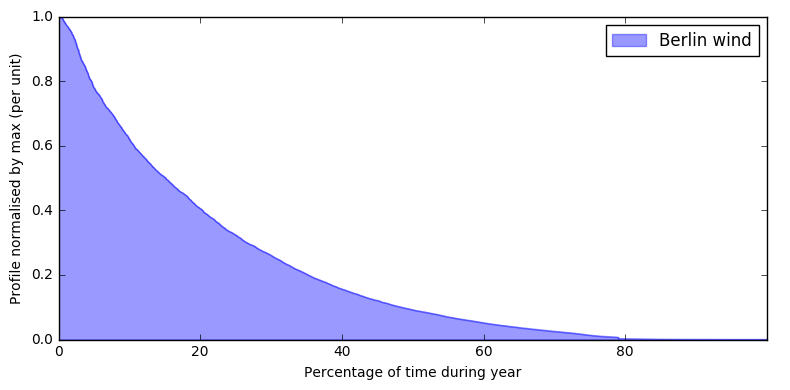

In [17]:

tech = "onwind"

norm = "max"

handles = []
labels = []


fig,ax = plt.subplots(1,1)

fig.set_size_inches(8,4)


alpha = 0.4

version = "berlin"

color="b"
label="Berlin wind"

duration_curve(berlin,percent=True).plot(kind="area",ax=ax,color=color,alpha=alpha,linewidth=1)
handles.append(Rectangle((0, 0), 1, 1, fc=color,color=color,alpha=alpha))
labels.append(label)

if version in ["de","eu"]:
    color="g"
    label="Germany onshore wind"
    duration_curve(de,percent=True).plot(kind="area",ax=ax,color=color,alpha=alpha,linewidth=1)
    handles.append(Rectangle((0, 0), 1, 1, fc=color,color=color,alpha=alpha))
    labels.append(label)

if version == "eu":
    color="k"
    label="Europe all wind"
    alpha=0.7
    duration_curve(eu,percent=True).plot(kind="area",alpha=alpha,ax=ax,color=color,linewidth=1)
    handles.append(Rectangle((0, 0), 1, 1, fc=color,color=color,alpha=alpha))
    labels.append(label)

ax.legend(handles,labels)

ax.set_ylabel("Profile normalised by "+norm+" (per unit)")

ax.set_xlabel("")

ax.set_ylim([0,1])

#ticks = range(0,24*14,48)

#ax.set_xticks(ticks)

#ax.set_xticklabels([berlin.loc[start:end].index[i][:10]  for i in ticks])

ax.set_xlabel("Percentage of time during year")

fig.tight_layout()

fig.savefig("duration-{}.pdf".format(version),transparent=True)

# Add EU

In [14]:
network.add("Bus","EU")

In [15]:

for tech in ["onwind","solar"]:
    
    selection = [tech]

    totalcap = network.generators.groupby(network.generators.carrier).sum().p_nom_opt[selection].sum()


    network.add("Generator","EU "+ tech,carrier=tech,bus="EU",p_max_pu=(p_series_avail[selection].sum(axis=1)/totalcap))


KeyError: "['onwind'] not in index"

In [63]:
network.add("Load","EU",bus="EU",p_set=network.loads_t.p_set.loc[:,network.loads.bus.map(network.buses.carrier) == "AC"].sum(axis=1))

ERROR:pypsa.components:Failed to add Load component EU because there is already an object with this name in loads


In [66]:
network.loads_t.p_set["EU"].describe()

count      8760.000000
mean     359907.142237
std       61307.083395
min      227628.000000
25%      312206.500000
50%      361618.000000
75%      400742.250000
max      517114.000000
Name: EU, dtype: float64

# Statistics

In [16]:
ct = "DE"
tech = "mismatch"

share = {"onwind" : 0.7, "solar": 0.3}


color = {"onwind" : "b","solar" : "y", "load" : "k", "mismatch" : "r", "real-wind" : "c", "real-pv" : "m"}[tech]

In [17]:
year = 2011

if tech == "load":
    s = network.loads_t.p_set[ct]/1e3
    srange = [0,100]
    kind = "area"
    units = "GW"
elif tech == "mismatch":
    
    df = pd.DataFrame(index = network.snapshots)

    df["load"] = network.loads_t.p_set[ct]/1e3
    for techr in share:
        df[techr + " pu"] = network.generators_t.p_max_pu.loc[:,(network.generators.bus==ct) & (network.generators.carrier==techr)].mean(axis=1)
        factor = share[techr]*df["load"].mean()/df[techr + " pu"].mean()
        print(techr,factor)
        df[techr] = df[techr + " pu"]*factor
        
    df.index = pd.date_range("2011-01-01 00:00","2011-12-31 23:00",freq="H")
    
    df["res"] = df[[t for t in share]].sum(axis=1)
    
    df["mismatch"] = df["load"] - df["res"]

    s = df["mismatch"]
    srange= [-150,80]
    kind="line"
    units = "GW"
elif tech in network.carriers.index:
    s = network.generators_t.p_max_pu.loc[:,(network.generators.bus==ct) & (network.generators.carrier==tech)].mean(axis=1)
    srange = [0,1]
    kind="area"
    units = "per unit"
    
else:
    
    year = 2012
    
    # www.pfbach.dk/firma_pfb/time_series/ts.php
    file_name = "/home/tom/store/energy/pfbach/{}_de_{}.xls".format(year,tech[5:])

    df = pd.read_excel(file_name,skiprows=3)
    kind="area"
    srange = [0,40]
    units="GW"
    
    s = df["MWh"]/1e3
    
s.index = pd.date_range("{}-01-01 00:00".format(year),"{}-12-31 23:00".format(year),freq="H")

solar 135.335915613
onwind 147.247821616


In [18]:
s.describe()

count    8759.000000
mean        0.000859
std        41.147562
min      -153.995700
25%       -28.942422
50%         8.075075
75%        34.785360
max        69.793887
Name: mismatch, dtype: float64

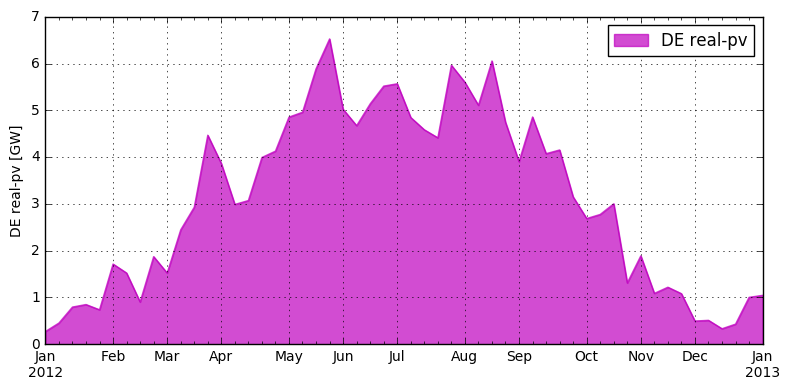

In [8]:
sample = "W"


fig,ax = plt.subplots(1,1)

fig.set_size_inches(8,4)

handles = []
labels = []



alpha =0.7

s.resample(sample).mean().plot(kind=kind,ax=ax,color=color,alpha=alpha,linewidth=1)


handles.append(Rectangle((0, 0), 1, 1, fc=color, color=color,alpha = alpha))
labels.append("{} {}".format(ct,tech))

ax.legend(handles,labels)

ax.set_ylabel("{} {} [{}]".format(ct,tech,units))

ax.grid(True)

fig.tight_layout()

if True:
    fig.savefig("{}-{}-{}.pdf".format(ct,tech,sample),transparent=True)

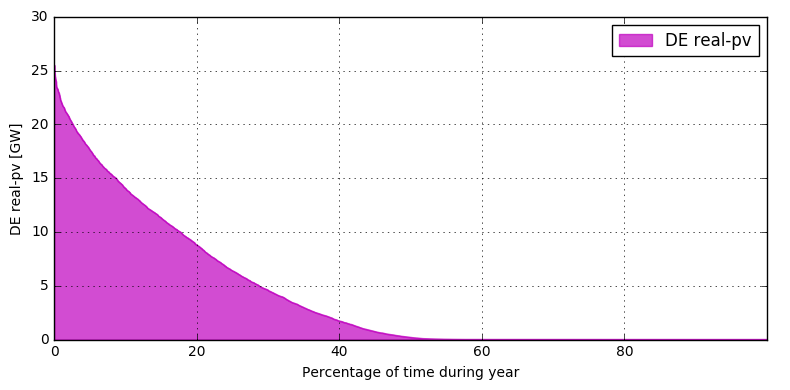

In [245]:

fig,ax = plt.subplots(1,1)

fig.set_size_inches(8,4)

handles = []
labels = []

alpha =0.7

duration_curve(s,percent=True).plot(kind=kind,ax=ax,color=color,alpha=alpha,linewidth=1)


handles.append(Rectangle((0, 0), 1, 1, fc=color, color=color,alpha = alpha))
labels.append("{} {}".format(ct,tech))

ax.legend(handles,labels)

ax.set_ylabel("{} {} [{}]".format(ct,tech,units))

ax.set_xlabel("Percentage of time during year")

ax.grid(True)

fig.tight_layout()

if True:
    fig.savefig("{}-{}-duration.pdf".format(ct,tech),transparent=True)

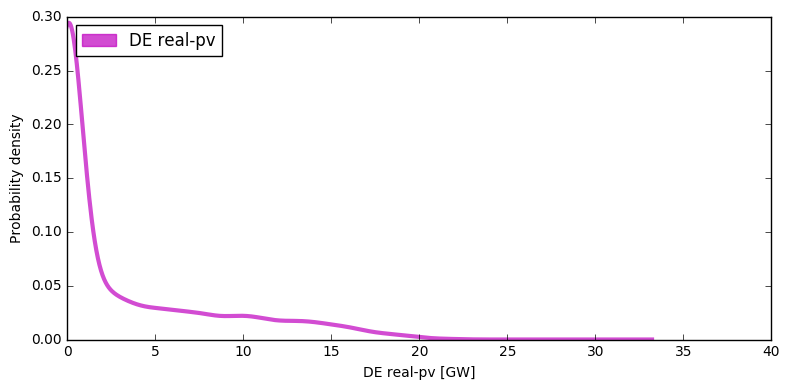

In [240]:

fig,ax = plt.subplots(1,1)

fig.set_size_inches(8,4)

handles = []
labels = []

alpha =0.7

s.plot(kind="kde",ax=ax,color=color,alpha=alpha,linewidth=3)


handles.append(Rectangle((0, 0), 1, 1, fc=color, color=color,alpha = alpha))
labels.append("{} {}".format(ct,tech))

ax.legend(handles,labels,loc="upper left")

ax.set_xlabel("{} {} [{}]".format(ct,tech,units))

ax.set_ylabel("Probability density")

ax.set_xlim(srange)

fig.tight_layout()

if True:
    fig.savefig("{}-{}-density.pdf".format(ct,tech),transparent=True)

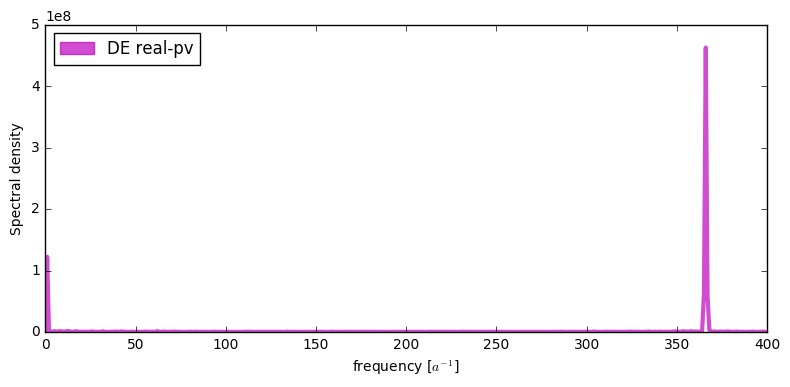

In [241]:


fig,ax = plt.subplots(1,1)

fig.set_size_inches(8,4)

handles = []
labels = []

alpha =0.7

rfft = abs(np.fft.rfft((s - s.mean()).fillna(0.)))**2

plt.plot(rfft[:400],color=color,alpha=alpha,linewidth=3)


handles.append(Rectangle((0, 0), 1, 1, fc=color, color=color,alpha = alpha))
labels.append("{} {}".format(ct,tech))

ax.legend(handles,labels,loc="upper left")

ax.set_xlabel("frequency [$a^{-1}$]")

ax.set_ylabel("Spectral density")

#ax.set_xlim([0,100])

fig.tight_layout()

if True:
    fig.savefig("{}-{}-spectrum.pdf".format(ct,tech),transparent=True)


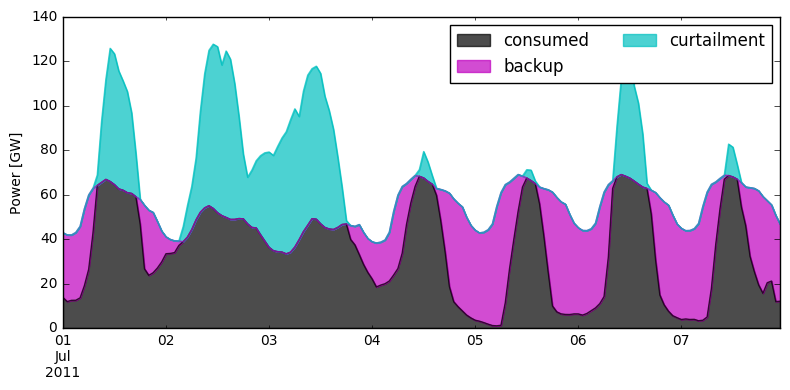

In [21]:

start = "2011-07-01"
end = "2011-07-07"

fig,ax = plt.subplots(1,1)

fig.set_size_inches(8,4)

handles = []
labels = []
 
#s = p_series[selection].sum(axis=1)+network.storage_units_t.p.sum(axis=1)
#(s/s.max()).loc[start:end].plot(ax=ax,linewidth=5,color="r")

#(load/load.max()).loc[start:end].plot(ax=ax,linewidth=5,color="r",label="load")
#((p_series_avail[selection].sum(axis=1)+network.storage_units_t.p.groupby(network.storage_units.source,axis=1).sum()["hydro"])/totalcap).loc[start:end].plot(kind="area",alpha=0.7,ax=ax,label="Europe all wind + hdyro",color="r")

diff = df["mismatch"].loc[start:end]

diffp = diff.copy()

diffp[diff<0] = 0.

diffn = diff.copy()

diffn[diffn>0] = 0.

#diffp.loc[start:end].plot()

#diffn.loc[start:end].plot()


eus = pd.DataFrame()

eus["consumed"] = df["load"].loc[start:end]-diffp

eus["backup"] = diffp

eus["curtailment"] = -diffn

color = ["k","m","c"]
alpha = 0.7

eus.loc[start:end].plot(kind="area",alpha=alpha,ax=ax,color=color,linewidth=1)

handles.extend([Rectangle((0, 0), 1, 1, color=color, fc=color, alpha=alpha) for color in color])
labels.extend(eus.columns)




#(p_series_avail_ct/getattr(p_series_avail_ct,norm)()).loc[start:end,country+ " " + tech + " available"].plot(kind="area",alpha=0.5,ax=ax,label="Germany wind")

#ax.fill_between(diff.index,eu,eu+diffp,color="m",alpha=0.7,label="hydro")

#color="r"
#linewidth=4
#(load/load.max()).loc[start:end].plot(ax=ax,linewidth=linewidth,color=color)

#handles.append(Line2D([0],[0],color="r",linewidth=linewidth))
#labels.append("Electrical Demand")
            
  

ax.legend(handles,labels,ncol=2)

ax.set_ylabel("Power [GW]")

ax.set_xlabel("")

#ax.set_ylim([0,1.15])

#ticks = range(0,24*14,48)

#ax.set_xticks(ticks)

#ax.set_xticklabels(["Dec " + berlin.loc[start:end].index[i][8:10]  for i in ticks])

fig.tight_layout()
if True:
    fig.savefig("mismatch-{}-{}.pdf".format(start,end),transparent=True)

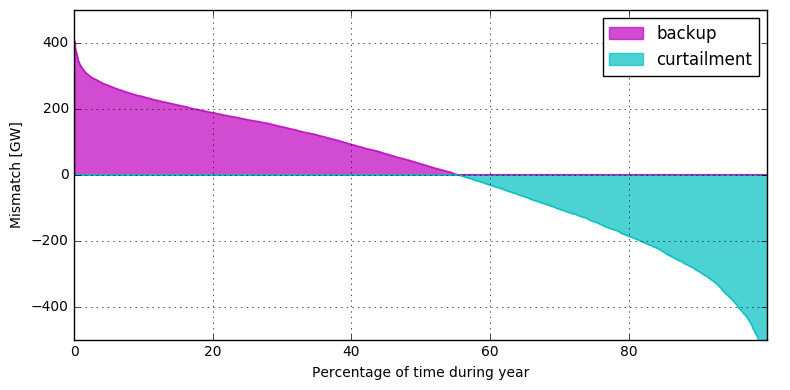

In [80]:

fig,ax = plt.subplots(1,1)

fig.set_size_inches(8,4)

alpha =0.7

diff = df["mismatch"]

diffp = diff.copy()

diffp[diff<0] = 0.

diffn = diff.copy()

diffn[diffn>0] = 0.

duration_curve(diffp,percent=True).plot(kind="area",ax=ax,color="m",alpha=alpha,linewidth=1)


duration_curve(diffn,percent=True).plot(kind="area",ax=ax,color="c",alpha=alpha,linewidth=1)

handles = []
labels = []



handles.append(Rectangle((0, 0), 1, 1, fc="m", color="m",alpha = alpha))
handles.append(Rectangle((0, 0), 1, 1, fc="c", color="c",alpha = alpha))
labels.append("backup")
labels.append("curtailment")

ax.legend(handles,labels)

ax.set_ylabel("Mismatch [GW]")

ax.set_xlabel("Percentage of time during year")

if ct == "DE":
    ax.set_ylim([-130,80])
elif ct == "EU":
    ax.set_ylim([-500,500])

ax.grid(True)

fig.tight_layout()

if True:
    fig.savefig("mismatch-duration-{}.pdf".format(ct),transparent=True)

In [81]:
diffp.sum()/df["load"].sum()

0.23582986576747528

In [83]:
diffp.max()/df["load"].mean()

1.1282190829647278

In [84]:
df["load"].mean()

359.90714223744294

In [210]:
file_name = "/home/tom/store/energy/pfbach/2011_de_wind.xls"

df = pd.read_excel(file_name,skiprows=3)

In [211]:
df

Unnamed: 0  Unnamed: 1    MWh
0    2011-01-01           1  10409
1    2011-01-01           2  11455
2    2011-01-01           3  12241
3    2011-01-01           4  12937
4    2011-01-01           5  13554
5    2011-01-01           6  13757
6    2011-01-01           7  13597
7    2011-01-01           8  13329
8    2011-01-01           9  13015
9    2011-01-01          10  12584
10   2011-01-01          11  12223
11   2011-01-01          12  11795
12   2011-01-01          13  11421
13   2011-01-01          14  11403
14   2011-01-01          15  10806
15   2011-01-01          16  10069
16   2011-01-01          17   9591
17   2011-01-01          18   9069
18   2011-01-01          19   8621
19   2011-01-01          20   7970
20   2011-01-01          21   7607
21   2011-01-01          22   7491
22   2011-01-01          23   6940
23   2011-01-01          24   6978
24   2011-01-02           1   6943
25   2011-01-02           2   6548
26   2011-01-02           3   6601
27   2011-01-02           4   6426
28   2011-01-02           5   6104
29   2011-01-02           6   5777
...         ...         ...    ...
8730 2011-12-30          19   8268
8731 2011-12-30          20   8103
8732 2011-12-30          21   7820
8733 2011-12-30          22   7040
8734 2011-12-30          23   6503
8735 2011-12-30          24   5813
8736 2011-12-31           1   5499
8737 2011-12-31           2   4969
8738 2011-12-31           3   4009
8739 2011-12-31           4   3515
8740 2011-12-31           5   2858
8741 2011-12-31           6   2504
8742 2011-12-31           7   2223
8743 2011-12-31           8   1774
8744 2011-12-31           9   1690
8745 2011-12-31          10   1674
8746 2011-12-31          11   1617
8747 2011-12-31          12   1725
8748 2011-12-31          13   1701
8749 2011-12-31          14   1530
8750 2011-12-31          15   1488
8751 2011-12-31          16   1610
8752 2011-12-31          17   1915
8753 2011-12-31          18   2338
8754 2011-12-31          19   2647
8755 2011-12-31          20   2718
8756 2011-12-31          21   2688
8757 2011-12-31          22   2751
8758 2011-12-31          23   2909
8759 2011-12-31          24   1689

[8760 rows x 3 columns]

In [45]:
df["load"].describe()

count    8760.000000
mean      719.814284
std       122.614167
min       455.256000
25%       624.413000
50%       723.236000
75%       801.484500
max      1034.228000
Name: load, dtype: float64

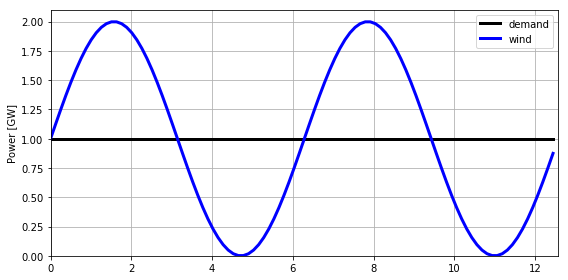

In [20]:
D = 1.
omega = 1.

T = 2*np.pi/omega

h = T/50.

x = np.arange(0,2*T,h)


fig,ax = plt.subplots(1,1)

fig.set_size_inches(8,4)

handles = []
labels = []
 
#s = p_series[selection].sum(axis=1)+network.storage_units_t.p.sum(axis=1)
#(s/s.max()).loc[start:end].plot(ax=ax,linewidth=5,color="r")

#(load/load.max()).loc[start:end].plot(ax=ax,linewidth=5,color="r",label="load")
#((p_series_avail[selection].sum(axis=1)+network.storage_units_t.p.groupby(network.storage_units.source,axis=1).sum()["hydro"])/totalcap).loc[start:end].plot(kind="area",alpha=0.7,ax=ax,label="Europe all wind + hdyro",color="r")

load = pd.Series(D,x)
wind = pd.Series(2*D*0.5*(1+np.sin(omega*x)),x)

df = pd.DataFrame({"demand" : load, "wind" : wind})

df.plot(ax=ax,color=["k","b"],linewidth=3)

  

ax.legend(ncol=1,loc="upper right")

ax.set_ylabel("Power [GW]")

ax.set_xlabel("")

ax.set_xlim([0,2*T])

ax.set_ylim([0,2.1])

ax.grid(True)

#ticks = range(0,24*14,48)

#ax.set_xticks(ticks)

#ax.set_xticklabels(["Dec " + berlin.loc[start:end].index[i][8:10]  for i in ticks])

fig.tight_layout()
fig.savefig("demand-wind.pdf",transparent=True)

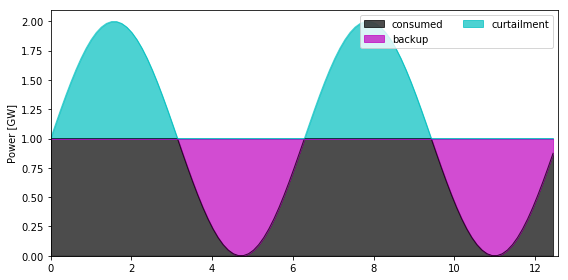

In [8]:
D = 1.
omega = 1.

T = 2*np.pi/omega

h = T/50.

x = np.arange(0,2*T,h)


fig,ax = plt.subplots(1,1)

fig.set_size_inches(8,4)

handles = []
labels = []
 
#s = p_series[selection].sum(axis=1)+network.storage_units_t.p.sum(axis=1)
#(s/s.max()).loc[start:end].plot(ax=ax,linewidth=5,color="r")

#(load/load.max()).loc[start:end].plot(ax=ax,linewidth=5,color="r",label="load")
#((p_series_avail[selection].sum(axis=1)+network.storage_units_t.p.groupby(network.storage_units.source,axis=1).sum()["hydro"])/totalcap).loc[start:end].plot(kind="area",alpha=0.7,ax=ax,label="Europe all wind + hdyro",color="r")

diff = pd.Series(-D*np.sin(omega*x),x)

diffp = diff.copy()

diffp[diff<0] = 0.

diffn = diff.copy()

diffn[diffn>0] = 0.

#diffp.loc[start:end].plot()

#diffn.loc[start:end].plot()


eus = pd.DataFrame()

eus["consumed"] = D-diffp

eus["backup"] = diffp

eus["curtailment"] = -diffn

color = ["k","m","c"]
alpha = 0.7

eus.plot(kind="area",alpha=alpha,ax=ax,color=color,linewidth=1)

handles.extend([Rectangle((0, 0), 1, 1, color=color, fc=color, alpha=alpha) for color in color])
labels.extend(eus.columns)




#(p_series_avail_ct/getattr(p_series_avail_ct,norm)()).loc[start:end,country+ " " + tech + " available"].plot(kind="area",alpha=0.5,ax=ax,label="Germany wind")

#ax.fill_between(diff.index,eu,eu+diffp,color="m",alpha=0.7,label="hydro")

#color="r"
#linewidth=4
#(load/load.max()).loc[start:end].plot(ax=ax,linewidth=linewidth,color=color)

#handles.append(Line2D([0],[0],color="r",linewidth=linewidth))
#labels.append("Electrical Demand")
            
  

ax.legend(handles,labels,ncol=2,loc="upper right")

ax.set_ylabel("Power [GW]")

ax.set_xlabel("")

ax.set_xlim([0,2*T])

#ticks = range(0,24*14,48)

#ax.set_xticks(ticks)

#ax.set_xticklabels(["Dec " + berlin.loc[start:end].index[i][8:10]  for i in ticks])

fig.tight_layout()
#fig.savefig("mismatch-sin.pdf",transparent=True)

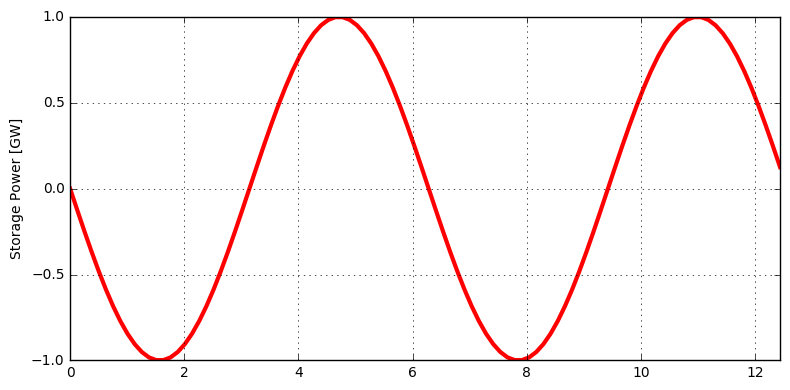

In [42]:
D = 1.
omega = 1.

T = 2*np.pi/omega

h = T/50.

x = np.arange(0,2*T,h)


fig,ax = plt.subplots(1,1)

fig.set_size_inches(8,4)

pd.Series(-D*np.sin(omega*x),x).plot(ax=ax,label="storage unit power",color="r",linewidth=3)

#ax.legend(handles,labels,ncol=2)

ax.set_ylabel("Storage Power [GW]")

ax.set_xlabel("")

ax.grid(True)

#ax.set_ylim([0,1.15])

#ticks = range(0,24*14,48)

#ax.set_xticks(ticks)

#ax.set_xticklabels(["Dec " + berlin.loc[start:end].index[i][8:10]  for i in ticks])

fig.tight_layout()
if True:
    fig.savefig("storage-power.pdf",transparent=True)

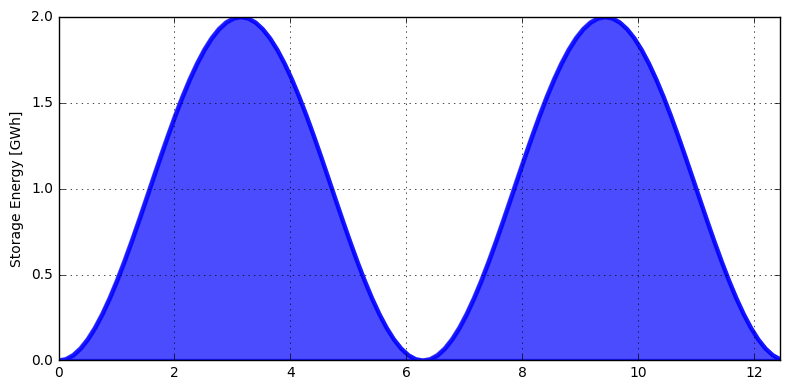

In [2]:
D = 1.
omega = 1.

T = 2*np.pi/omega

h = T/50.

x = np.arange(0,2*T,h)


fig,ax = plt.subplots(1,1)

fig.set_size_inches(8,4)

pd.Series((D/omega)*(1-np.cos(omega*x)),x).plot(kind="area",alpha=0.7,ax=ax,label="storage unit power",color="b",linewidth=3)

#ax.legend(handles,labels,ncol=2)

ax.set_ylabel("Storage Energy [GWh]")

ax.set_xlabel("")

ax.grid(True)

#ax.set_ylim([0,1.15])

#ticks = range(0,24*14,48)

#ax.set_xticks(ticks)

#ax.set_xticklabels(["Dec " + berlin.loc[start:end].index[i][8:10]  for i in ticks])

fig.tight_layout()
if True:
    fig.savefig("storage-energy.pdf",transparent=True)